# Constrained K-Means demo - Cluto dataset

## H2O K-Means algorithm

K-Means falls in the general category of clustering algorithms. Clustering is a form of unsupervised learning that tries to find structures in the data without using any labels or target values. Clustering partitions a set of observations into separate groupings such that observation in a given group is more similar to another observation in the same group than to another observation in a different group.

![kmeans](https://media0.giphy.com/media/12vVAGkaqHUqCQ/giphy.gif?cid=790b7611178aaedddb5b58de2ef94d55dc6c3feecd2d02f2&rid=giphy.gif)

More about H2O K-means Clustering: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/k-means.html

## Constrained K-Means algorithm in H2O

Using the `cluster_size_constraints` parameter, a user can set the minimum size of each cluster during the training by an array of numbers. The size of the array must be equal as the `k` parameter.

To satisfy the custom minimal cluster size, the calculation of clusters is converted to the Minimal Cost Flow problem. Instead of using the Lloyd iteration algorithm, a graph is constructed based on the distances and constraints. The goal is to go iteratively through the input edges and create an optimal spanning tree that satisfies the constraints.

![mcf](https://adared.ch/wp-content/uploads/2015/11/mcf.png)

More information about how to convert the standard K-means algorithm to the Minimal Cost Flow problem is described in this paper: https://pdfs.semanticscholar.org/ecad/eb93378d7911c2f7b9bd83a8af55d7fa9e06.pdf.

**Minimum-cost flow problem can be efficiently solved in polynomial time. Currently, the performance of this implementation of Constrained K-means algorithm is slow due to many repeatable calculations which cannot be parallelized and more optimized at H2O backend.**

Expected time with various sized data:
* 5 000 rows, 5 features   ~ 0h  4m  3s
* 10 000 rows, 5 features  ~ 0h  9m 21s
* 15 000 rows, 5 features  ~ 0h 22m 25s
* 20 000 rows, 5 features  ~ 0h 39m 27s
* 25 000 rows, 5 features  ~ 1h 06m  8s
* 30 000 rows, 5 features  ~ 1h 26m 43s
* 35 000 rows, 5 features  ~ 1h 44m  7s
* 40 000 rows, 5 features  ~ 2h 13m 31s
* 45 000 rows, 5 features  ~ 2h  4m 29s
* 50 000 rows, 5 features  ~ 4h  4m 18s

(OS debian 10.0 (x86-64), processor Intel© Core™ i7-7700HQ CPU @ 2.80GHz × 4, RAM 23.1 GiB)

## Shorter time using Aggregator Model

To solve Constrained K-means in a shorter time, you can used the H2O Aggregator model to aggregate data to smaller size first and then pass these data to the Constrained K-means model to calculate the final centroids to be used with scoring. The results won't be as accurate as a result from a model with the whole dataset. However, it should help solve the problem of a huge datasets.

However, there are some assumptions:
* the large dataset has to consist of many similar data points - if not, the insensitive aggregation can break the structure of the dataset
* the resulting clustering may not meet the initial constraints exactly when scoring (this also applies to Constrained K-means model, scoring use only result centroids to score and no constraints defined before)

The H2O Aggregator method is a clustering-based method for reducing a numerical/categorical dataset into a dataset with fewer rows. Aggregator maintains outliers as outliers but lumps together dense clusters into exemplars with an attached count column showing the member points.

More about H2O Aggregator: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/aggregator.html

In [2]:
# run h2o Kmeans

# Import h2o library
import h2o
from h2o.estimators import H2OKMeansEstimator

# init h2o cluster
h2o.init(strict_version_check=False, url="http://192.168.59.147:54321")

versionFromGradle='3.29.0',projectVersion='3.29.0.99999',branch='maurever_PUBDEV-6447_constrained_kmeans_improvement',lastCommitHash='162ceb18eae8b773028f27b284129c3ef752d001',gitDescribe='jenkins-master-4952-11-g162ceb18ea-dirty',compiledOn='2020-02-20 15:01:59',compiledBy='mori'
Checking whether there is an H2O instance running at http://192.168.59.147:54321 . connected.


H2O cluster uptime:,12 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.29.0.99999
H2O cluster version age:,1 hour and 17 minutes
H2O cluster name:,mori
H2O cluster total nodes:,1
H2O cluster free memory:,4.821 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [3]:
# import time to measure elapsed time
from timeit import default_timer as timer
from datetime import timedelta
import time

start = timer()
end = timer()
print("Time:", timedelta(seconds=end-start))

Time: 0:00:00.000010


## Data - Cluto-t7.10k

source: G. Karypis, "CLUTO A Clustering Toolkit," Dept. of Computer Science, University of Minnesota, Tech. Rep. 02-017, 2002, available at http://www.cs.umn.edu/~cluto. Karypis, George, Eui-Hong Han, and Vipin Kumar.

- 10 000 rows
- 3 features (x, y, class {0,1,2,3,4,5,6,7,8,noise})


In [4]:
# load data
import pandas as pd
cluto = pd.read_csv("../../smalldata/cluto/cluto_t7_10k.csv", header=None)
cluto.columns = ["x", "y", "class"]
cluto.loc[cluto["class"] == "noise", "class"] = 9
cluto["class"] = cluto["class"].astype("category")
cluto

,x,y,class
0,539.512024,411.975006,1
1,542.241028,147.626007,2
2,653.468994,370.727997,0
3,598.585999,284.882996,1
4,573.062988,294.562988,1
5,139.570007,401.381012,6
6,228.970001,281.992004,6
7,305.747009,94.350998,7
8,610.617004,167.190002,1
9,500.450012,118.780998,2


In [5]:
import matplotlib.pyplot as plt
groups = cluto.groupby('class')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=7, label=name)
fig.suptitle("Original Cluto dataset", fontsize=20)    
ax.legend(numpoints=1)

In [6]:
# load data to h2o
data_h2o_cluto = h2o.H2OFrame(cluto)

# run h2o Kmeans to estimate good start points
h2o_km_cluto = H2OKMeansEstimator(k=10, init="furthest", standardize=True)

start = timer()
h2o_km_cluto.train(x=["x", "y"], training_frame=data_h2o_cluto)
end = timer()

user_points = h2o.H2OFrame(h2o_km_cluto.centers())

# show details
h2o_km_cluto.show()
print("Time:", timedelta(seconds=end-start))

Parse progress: |█████████████████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1582207404277_1


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,10000.0,10.0,0.0,10.0,1667.636656,19998.0,18330.363344




ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 1666.5094477161151
Total Sum of Square Error to Grand Mean: 19998.000020727988
Between Cluster Sum of Square Error: 18331.490573011873

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,1041.0,179.995729
1,,2.0,973.0,157.996571
2,,3.0,1171.0,208.030397
3,,4.0,1008.0,112.034030
4,,5.0,855.0,123.911769
5,,6.0,1065.0,190.608740
6,,7.0,981.0,152.060651
7,,8.0,973.0,159.002221
8,,9.0,899.0,145.266071
9,,10.0,1034.0,237.603267



Scoring History: 


,,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2020-02-20 15:03:38,0.058 sec,0.0,NaN,NaN
1,,2020-02-20 15:03:38,0.208 sec,1.0,10000.0,2603.218838
2,,2020-02-20 15:03:38,0.244 sec,2.0,993.0,1865.508498
3,,2020-02-20 15:03:38,0.254 sec,3.0,456.0,1772.786949
4,,2020-02-20 15:03:38,0.267 sec,4.0,329.0,1725.575052
5,,2020-02-20 15:03:38,0.278 sec,5.0,231.0,1699.701634
6,,2020-02-20 15:03:38,0.289 sec,6.0,177.0,1687.171620
7,,2020-02-20 15:03:38,0.302 sec,7.0,142.0,1678.999864
8,,2020-02-20 15:03:38,0.309 sec,8.0,127.0,1673.706844
9,,2020-02-20 15:03:38,0.314 sec,9.0,99.0,1669.989434


Time: 0:00:00.565814


In [7]:
# run h2o constrained Kmeans
h2o_km_co_cluto = H2OKMeansEstimator(k=10, user_points=user_points, cluster_size_constraints=[100, 200, 100, 200, 100, 100, 100, 100, 100, 100], standardize=True)

start = timer()
h2o_km_co_cluto.train(x=["x", "y"], training_frame=data_h2o_cluto)
end = timer()

# show details
h2o_km_co_cluto.show()
time_h2o_km_co_cluto = timedelta(seconds=end-start)
print("Time:", time_h2o_km_co_cluto)

kmeans Model Build progress: |████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1582207404277_2


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,10000.0,10.0,0.0,10.0,1664.966569,19998.0,18333.033431




ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 1664.9665694840944
Total Sum of Square Error to Grand Mean: 19997.999999999996
Between Cluster Sum of Square Error: 18333.0334305159

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,1011.0,170.119422
1,,2.0,993.0,165.447394
2,,3.0,1176.0,208.789514
3,,4.0,997.0,109.136555
4,,5.0,859.0,124.607615
5,,6.0,1062.0,191.610032
6,,7.0,966.0,145.764267
7,,8.0,959.0,155.069414
8,,9.0,906.0,147.223218
9,,10.0,1071.0,247.199140



Scoring History: 


,,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2020-02-20 15:03:39,0.011 sec,0.0,NaN,NaN
1,,2020-02-20 15:04:26,47.307 sec,1.0,10000.0,1666.509446
2,,2020-02-20 15:05:00,1 min 21.174 sec,2.0,42.0,1666.002233
3,,2020-02-20 15:05:40,2 min 1.024 sec,3.0,32.0,1665.601672
4,,2020-02-20 15:06:17,2 min 38.436 sec,4.0,18.0,1665.330971
5,,2020-02-20 15:06:50,3 min 11.585 sec,5.0,21.0,1665.222647
6,,2020-02-20 15:07:28,3 min 49.345 sec,6.0,16.0,1665.083857
7,,2020-02-20 15:08:06,4 min 27.729 sec,7.0,15.0,1665.013420
8,,2020-02-20 15:08:44,5 min 4.867 sec,8.0,4.0,1664.971517
9,,2020-02-20 15:09:21,5 min 42.196 sec,9.0,1.0,1664.967125


Time: 0:06:17.922825


In [8]:
from h2o.estimators.aggregator import H2OAggregatorEstimator

# original data size 10000, constraints [100, 200, 100, 200, 100, 100, 100, 100, 100, 100]
# aggregated data size 5000, constaints [50, 100, 50, 100, 50, 50, 50, 50, 50, 50]

params = {
    "target_num_exemplars": 5000,
    "rel_tol_num_exemplars": 0.5,
    "categorical_encoding": "eigen"
}
agg = H2OAggregatorEstimator(**params)

start = timer()
agg.train(x=["x","y","class"], training_frame=data_h2o_cluto)
data_agg_12_cluto = agg.aggregated_frame

# run h2o Kmeans
h2o_km_co_agg_12_cluto = H2OKMeansEstimator(k=10, user_points=user_points, cluster_size_constraints=[50, 100, 50, 100, 50, 50, 50, 50, 50, 50], standardize=True)

h2o_km_co_agg_12_cluto.train(x=["x", "y"],training_frame=data_agg_12_cluto)
end = timer()

# show details
h2o_km_co_agg_12_cluto.show()
time_h2o_km_co_agg_12_cluto = timedelta(seconds=end-start)
print("Time:", time_h2o_km_co_agg_12_cluto)

aggregator Model Build progress: |████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1582207404277_4


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,4704.0,10.0,0.0,10.0,833.419474,9406.0,8572.580526




ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 833.4194743305884
Total Sum of Square Error to Grand Mean: 9406.000000000002
Between Cluster Sum of Square Error: 8572.580525669413

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,495.0,89.102803
1,,2.0,451.0,81.021073
2,,3.0,549.0,103.322650
3,,4.0,447.0,52.938713
4,,5.0,403.0,65.250578
5,,6.0,509.0,98.360575
6,,7.0,458.0,76.074637
7,,8.0,448.0,73.799758
8,,9.0,441.0,76.886811
9,,10.0,503.0,116.661877



Scoring History: 


,,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2020-02-20 15:09:58,0.004 sec,0.0,NaN,NaN
1,,2020-02-20 15:10:12,14.465 sec,1.0,4704.0,836.396491
2,,2020-02-20 15:10:24,26.487 sec,2.0,29.0,834.019564
3,,2020-02-20 15:10:36,38.478 sec,3.0,18.0,833.666722
4,,2020-02-20 15:10:48,50.340 sec,4.0,12.0,833.523871
5,,2020-02-20 15:11:00,1 min 2.571 sec,5.0,4.0,833.471111
6,,2020-02-20 15:11:13,1 min 14.848 sec,6.0,3.0,833.457722
7,,2020-02-20 15:11:24,1 min 26.745 sec,7.0,6.0,833.448221
8,,2020-02-20 15:11:37,1 min 39.728 sec,8.0,3.0,833.432040
9,,2020-02-20 15:11:49,1 min 51.767 sec,9.0,2.0,833.424375


Time: 0:02:05.151901


In [9]:
# original data size 10000, constraints [100, 200, 100, 200, 100, 100, 100, 100, 100, 100]
# aggregated data size 2500, constaints [50, 100, 50, 100, 50, 50, 50, 50, 50, 50]

params = {
    "target_num_exemplars": 2500,
    "rel_tol_num_exemplars": 0.5,
    "categorical_encoding": "eigen"
}
agg_14 = H2OAggregatorEstimator(**params)

start = timer()
agg_14.train(x=["x","y","class"], training_frame=data_h2o_cluto)
data_agg_14_cluto = agg_14.aggregated_frame

# run h2o Kmeans
h2o_km_co_agg_14_cluto = H2OKMeansEstimator(k=10, user_points=user_points, cluster_size_constraints=[25, 50, 25, 50, 25, 25, 25, 25, 25, 25], standardize=True)

h2o_km_co_agg_14_cluto.train(x=["x","y"],training_frame=data_agg_14_cluto)
end = timer()

# show details
h2o_km_co_agg_14_cluto.show()
time_h2o_km_co_agg_14_cluto = timedelta(seconds=end-start)
print("Time:", time_h2o_km_co_agg_14_cluto)

aggregator Model Build progress: |████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1582207404277_6


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,1998.0,10.0,0.0,10.0,386.550663,3994.0,3607.449337




ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 386.55066275115064
Total Sum of Square Error to Grand Mean: 3993.999999999999
Between Cluster Sum of Square Error: 3607.4493372488487

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,219.0,44.646723
1,,2.0,197.0,39.017929
2,,3.0,223.0,46.074045
3,,4.0,184.0,25.204827
4,,5.0,188.0,32.548179
5,,6.0,215.0,46.961160
6,,7.0,195.0,35.921999
7,,8.0,200.0,35.803402
8,,9.0,187.0,36.819424
9,,10.0,190.0,43.552975



Scoring History: 


,,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2020-02-20 15:12:02,0.001 sec,0.0,NaN,NaN
1,,2020-02-20 15:12:08,5.375 sec,1.0,1998.0,394.928571
2,,2020-02-20 15:12:13,10.380 sec,2.0,31.0,388.292709
3,,2020-02-20 15:12:18,15.378 sec,3.0,21.0,387.354860
4,,2020-02-20 15:12:22,20.198 sec,4.0,10.0,387.051973
5,,2020-02-20 15:12:27,24.858 sec,5.0,9.0,386.968308
6,,2020-02-20 15:12:32,29.360 sec,6.0,8.0,386.847480
7,,2020-02-20 15:12:36,34.053 sec,7.0,8.0,386.732143
8,,2020-02-20 15:12:42,39.803 sec,8.0,5.0,386.664586
9,,2020-02-20 15:12:47,44.387 sec,9.0,5.0,386.607298


Time: 0:00:49.909734


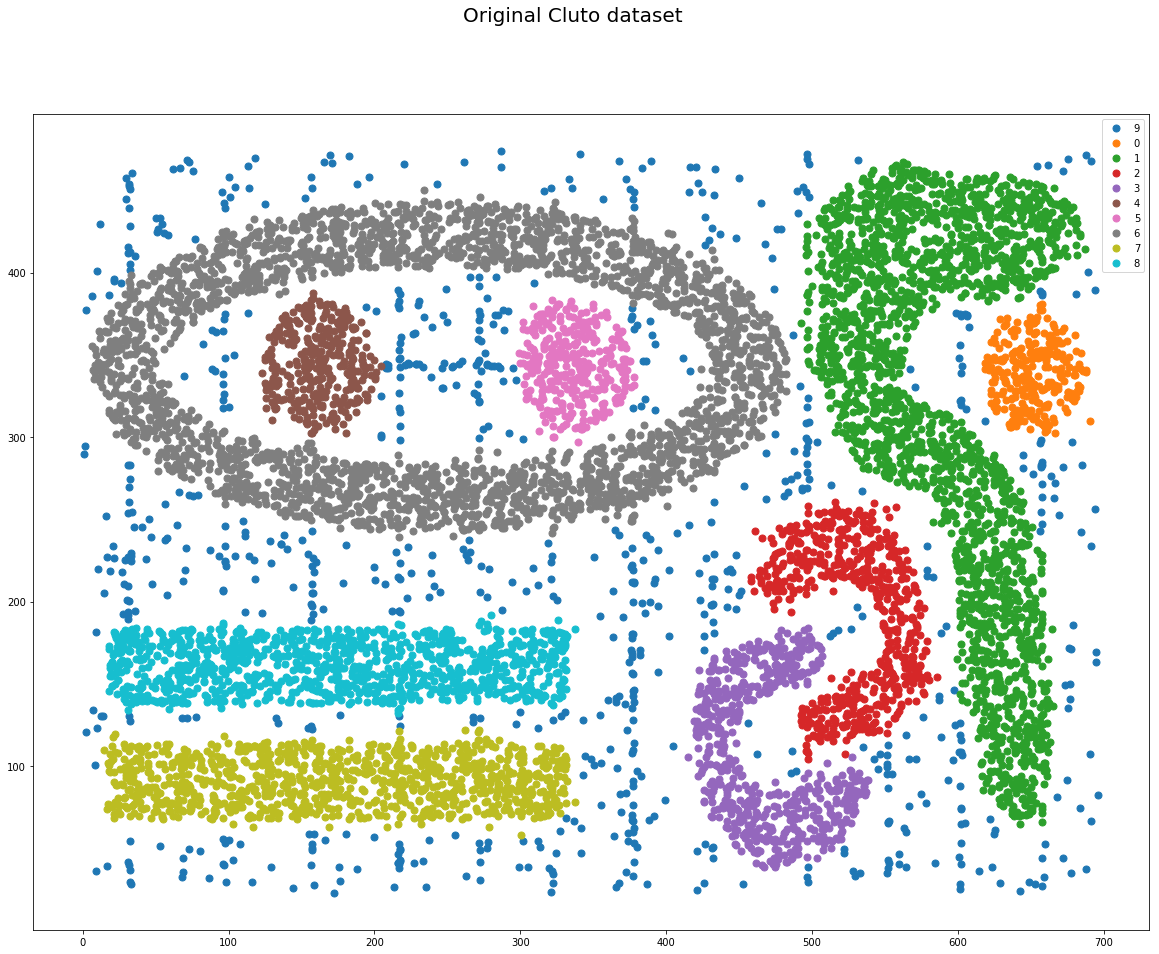

In [10]:
groups = cluto.groupby('class')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=7, label=name)

fig.suptitle("Original Cluto dataset", fontsize=20)
ax.legend(numpoints=1)

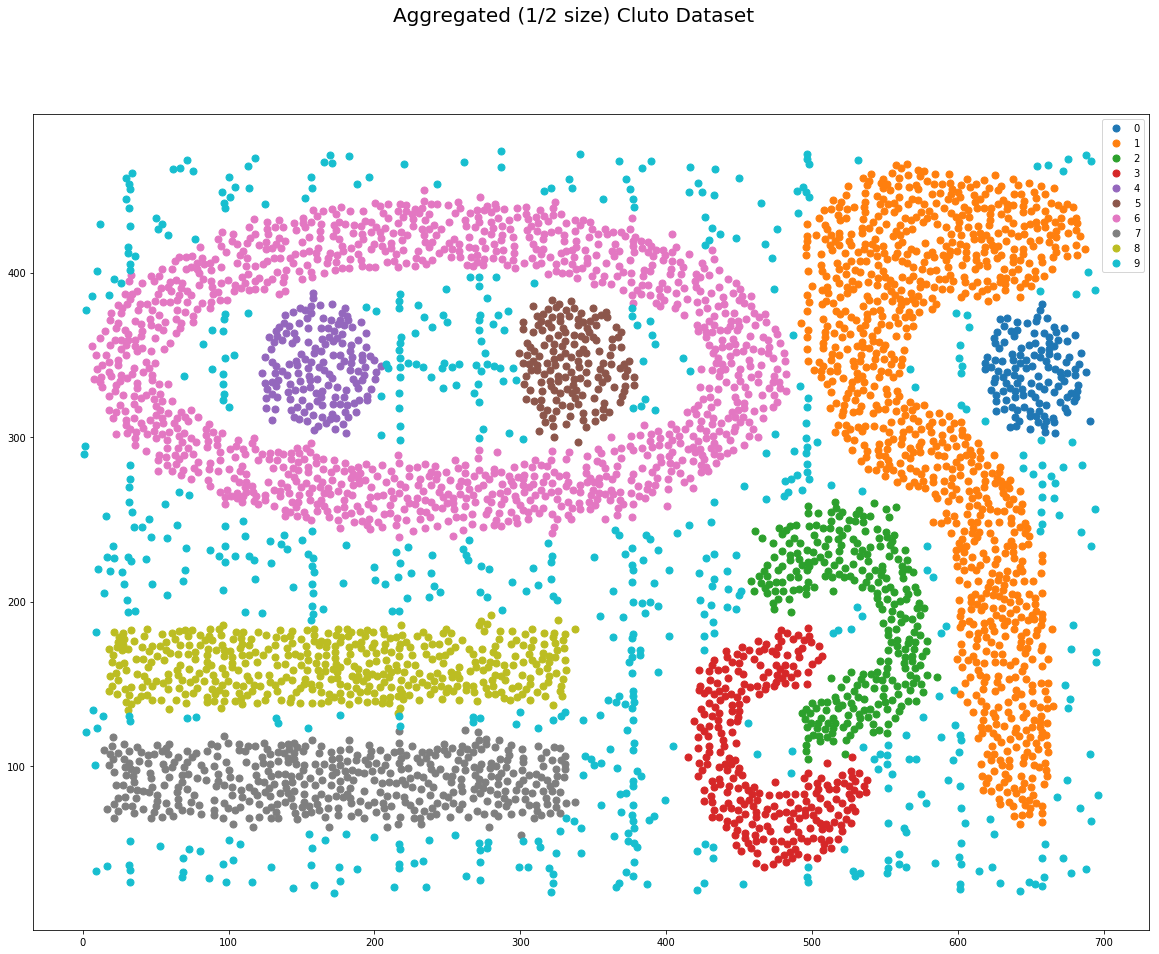

In [11]:
data_agg_df_12_cluto = data_agg_12_cluto.as_data_frame()
data_agg_df_12_cluto["class"] = data_agg_df_12_cluto["class"].astype("category")

groups = data_agg_df_12_cluto.groupby('class')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=7, label=name)

fig.suptitle("Aggregated (1/2 size) Cluto Dataset", fontsize=20)  
ax.legend(numpoints=1)

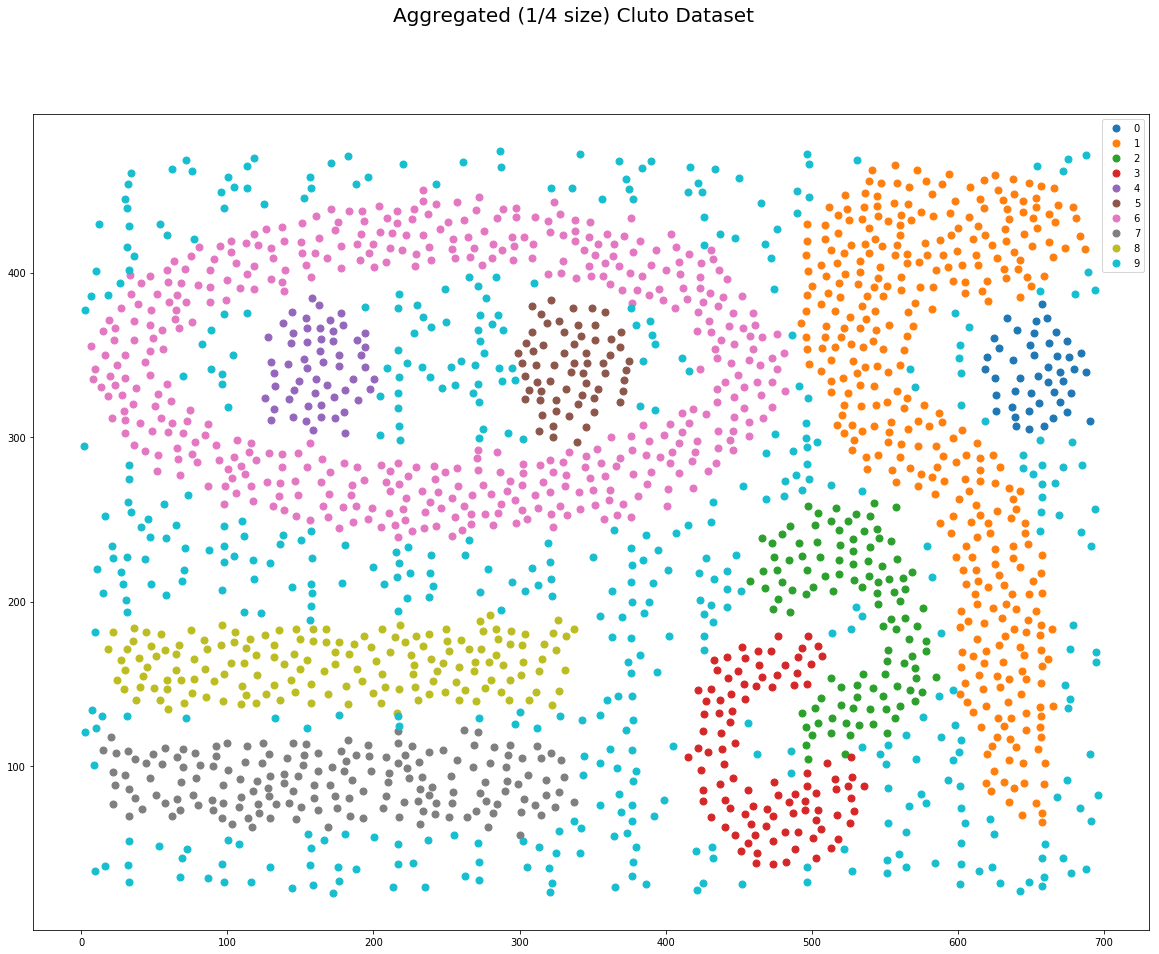

In [12]:
data_agg_df_14_cluto = data_agg_14_cluto.as_data_frame()
data_agg_df_14_cluto["class"] = data_agg_df_14_cluto["class"].astype("category")

groups = data_agg_df_14_cluto.groupby('class')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=7, label=name)

fig.suptitle("Aggregated (1/4 size) Cluto Dataset", fontsize=20)  
ax.legend(numpoints=1)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


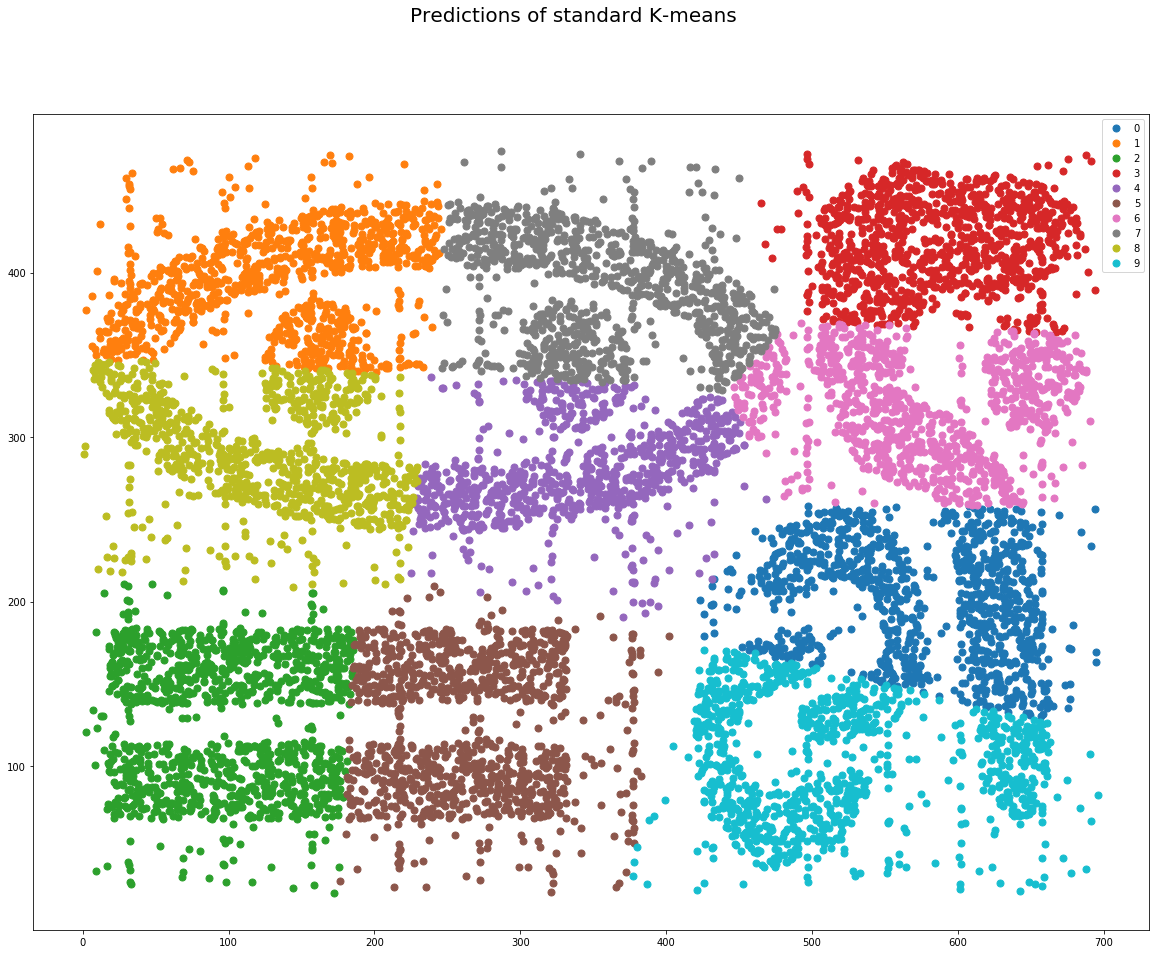

In [13]:
cluto["km_pred"] = h2o_km_cluto.predict(data_h2o_cluto).as_data_frame()['predict'].astype("category")

groups = cluto.groupby('km_pred')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=7, label=name)

fig.suptitle("Predictions of standard K-means", fontsize=20)  
ax.legend(numpoints=1)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


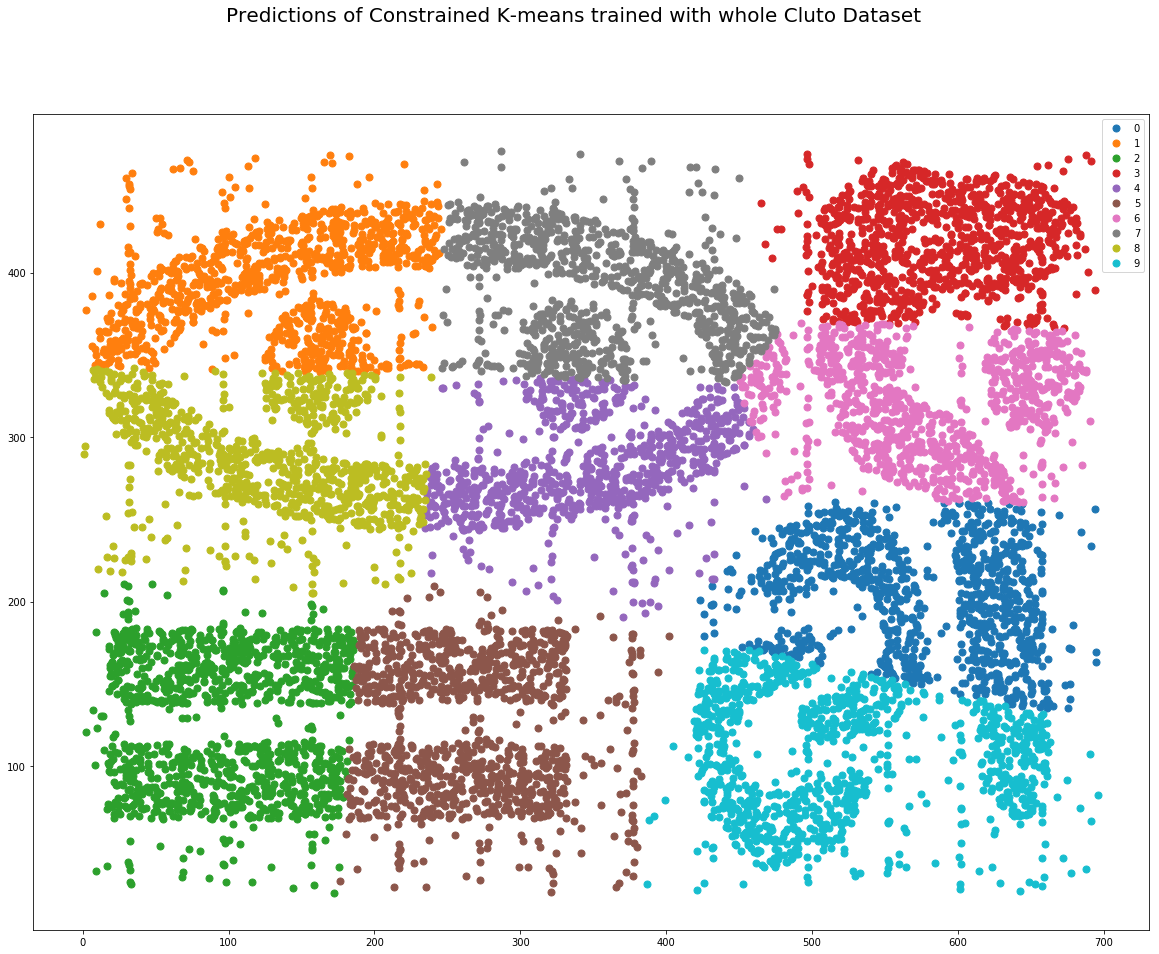

In [14]:
cluto["km_co_pred"] = h2o_km_co_cluto.predict(data_h2o_cluto).as_data_frame()['predict'].astype("category")
groups = cluto.groupby('km_co_pred')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=7, label=name)

fig.suptitle("Predictions of Constrained K-means trained with whole Cluto Dataset", fontsize=20)  
ax.legend(numpoints=1)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


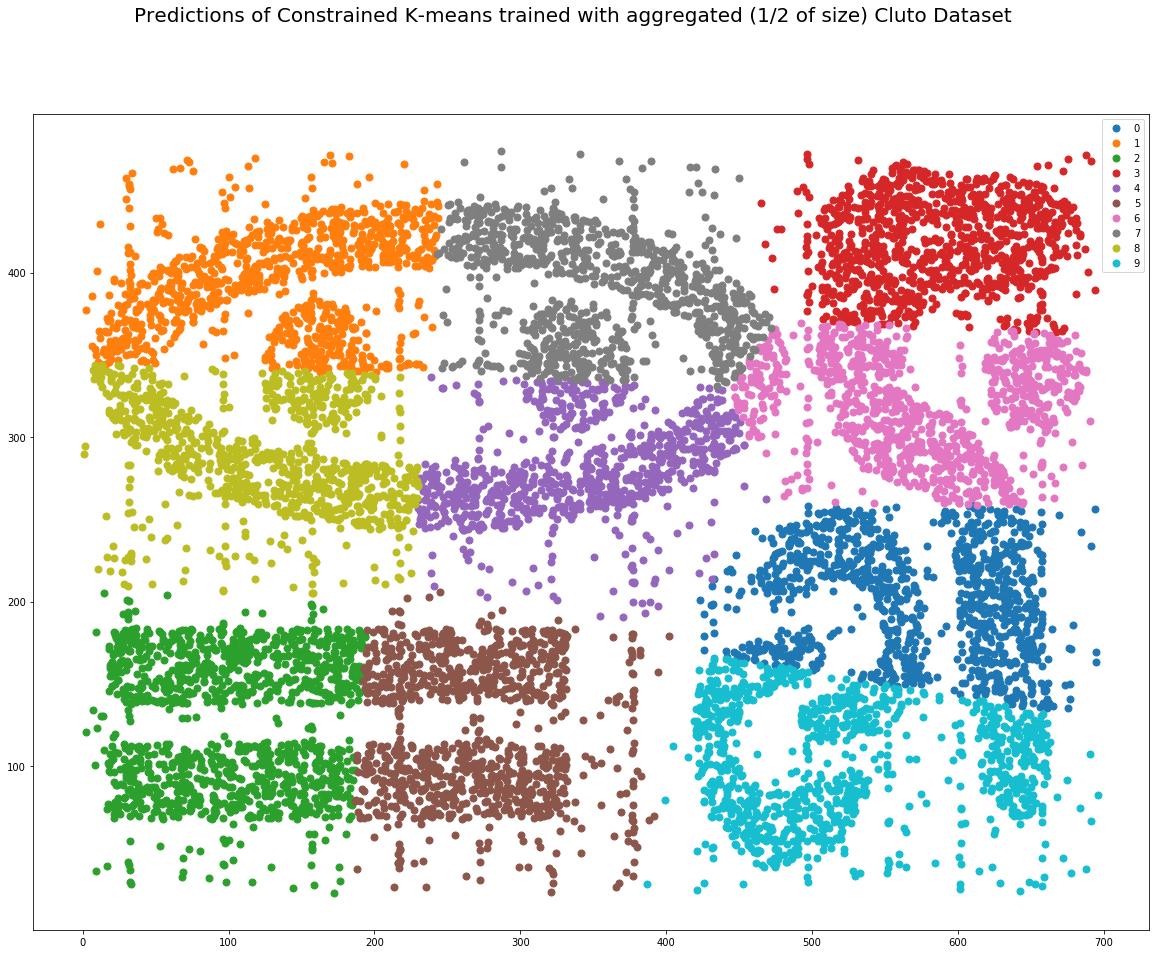

In [15]:
cluto["km_co_pred_1/2"] = h2o_km_co_agg_12_cluto.predict(data_h2o_cluto).as_data_frame()['predict'].astype("category")

groups = cluto.groupby('km_co_pred_1/2')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=7, label=name)

fig.suptitle("Predictions of Constrained K-means trained with aggregated (1/2 of size) Cluto Dataset", fontsize=20)  
ax.legend(numpoints=1)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


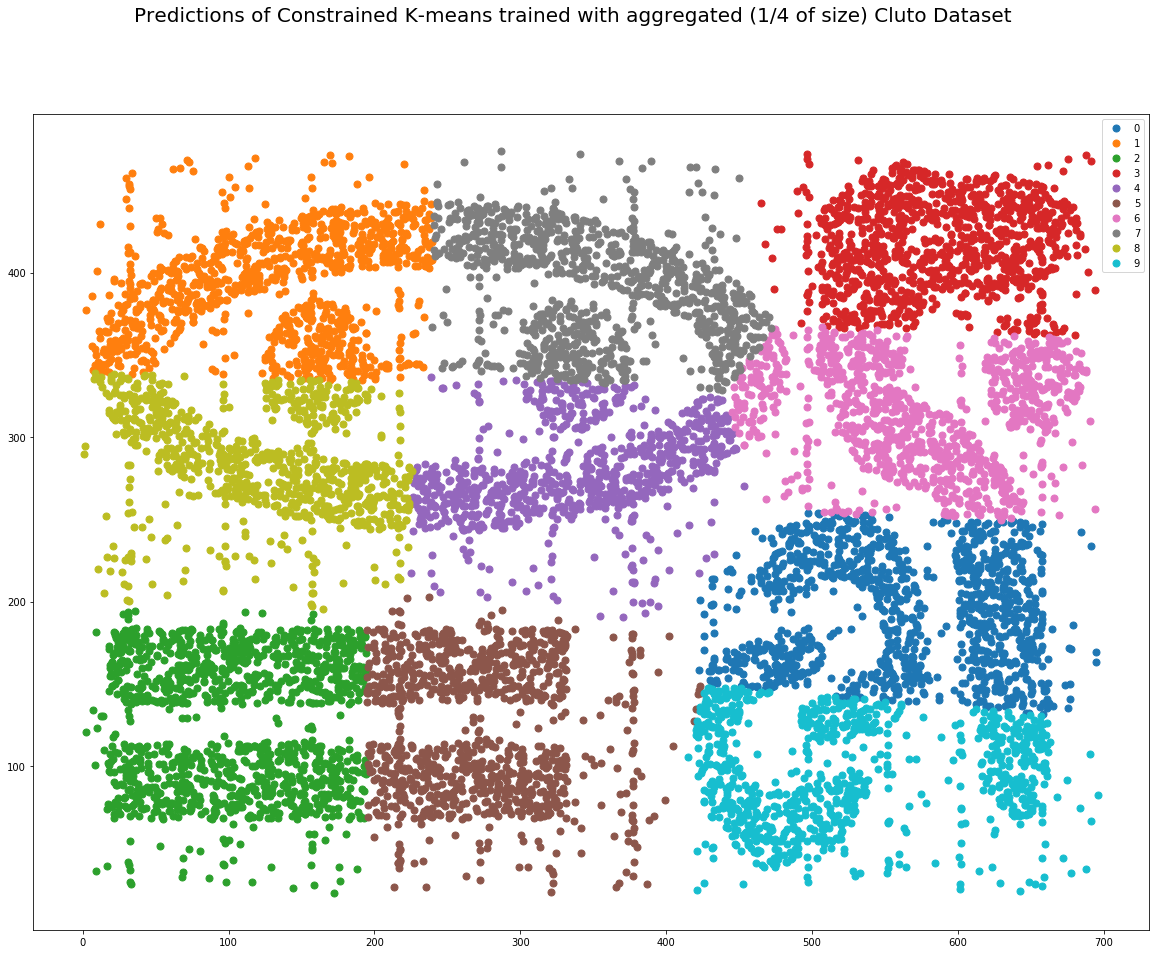

In [16]:
cluto["km_co_pred_1/4"] = h2o_km_co_agg_14_cluto.predict(data_h2o_cluto).as_data_frame()['predict'].astype("category")

groups = cluto.groupby('km_co_pred_1/4')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=7, label=name)

fig.suptitle("Predictions of Constrained K-means trained with aggregated (1/4 of size) Cluto Dataset", fontsize=20)  
ax.legend(numpoints=1)

## Difference between result centroids calculated based on all data and aggregated data

In [17]:
centers_km_co_cluto = pd.DataFrame(h2o_km_co_cluto.centers())
centers_km_co_cluto["algo"] =  "km_co"
centers_km_co_agg_12_cluto = pd.DataFrame(h2o_km_co_agg_12_cluto.centers())
centers_km_co_agg_12_cluto["algo"] =  "km_co_agg_1/2"
centers_km_co_agg_14_cluto = pd.DataFrame(h2o_km_co_agg_14_cluto.centers())
centers_km_co_agg_14_cluto["algo"] =  "km_co_agg_1/4"

centers_all_cluto = pd.concat([centers_km_co_cluto, centers_km_co_agg_12_cluto, centers_km_co_agg_14_cluto])
centers_all_cluto

,0,1,algo
0,573.728842,203.508799,km_co
1,133.744288,393.898371,km_co
2,100.095328,126.964439,km_co
3,585.305011,418.143112,km_co
4,345.861888,281.141212,km_co
5,266.990470,122.451603,km_co
6,578.007404,318.342757,km_co
7,355.965845,389.771451,km_co
8,128.568808,286.907431,km_co
9,521.531612,104.519515,km_co


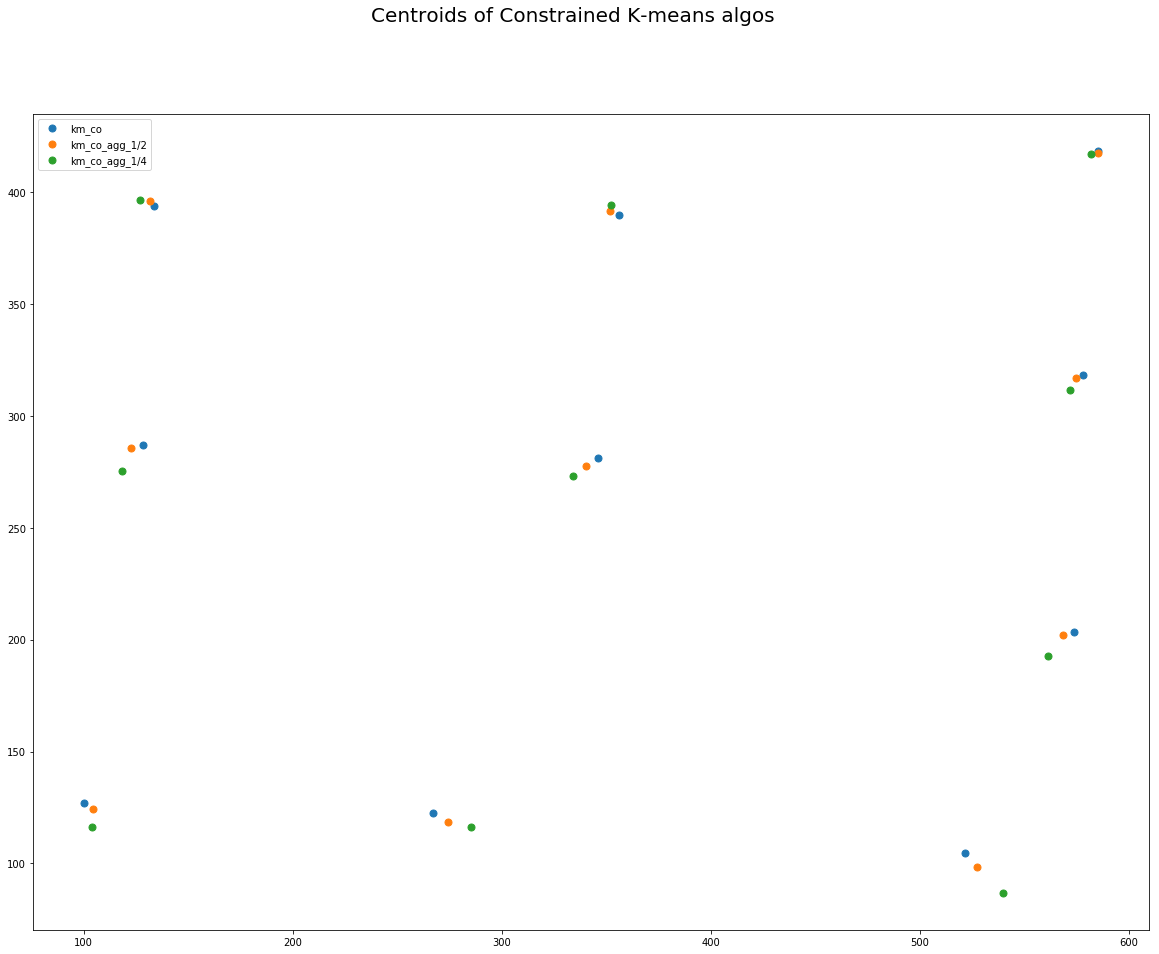

In [18]:
groups = centers_all_cluto.groupby('algo')
fig, ax = plt.subplots(1,1,figsize=(20,15))


for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', ms=7, label=name)

fig.suptitle("Centroids of Constrained K-means algos", fontsize=20)  
ax.legend(numpoints=1)